# Setup environment

In [ ]:
# prompt: auto reload modules
%load_ext autoreload
%autoreload 2


In [ ]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/')
    data_folder = Path('/content')

    # !pip install pytorch-lightning -U -qq
    !pip install pytorch-lightning==2.0.9 -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq

else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 30.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.2 MB/s eta 0:00:00


In [ ]:
!pip show pytorch-lightning

Name: pytorch-lightning
Version: 2.0.9
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/Lightning-AI/lightning
Author: Lightning AI et al.
Author-email: pytorch@lightning.ai
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: fsspec, lightning-utilities, numpy, packaging, PyYAML, torch, torchmetrics, tqdm, typing-extensions
Required-by: 


In [ ]:
custom_function_folder = base_folder/'data/custom-functions/fall_2023'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'data/models/dl_fall_2023/fmnist/'
model_folder.mkdir(parents=True, exist_ok=True)
project_folder = base_folder/'data/fmnist'


In [ ]:
# import Libraries
import yaml

import torch
import torch.nn as nn
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc

from data_module_fmnist import FashionMNISTDataModule
from multiclass_lightning_module_v0 import MultiClassLightningModule
from shared_utils import  plot_losses_acc

# Model

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.main_path(x)
        residual = self.downsample(residual)
        out += residual
        out = nn.ReLU(inplace=True)(out)
        return out

class SimpleResNetFMNIST(nn.Module):
    def __init__(self, num_classes=10):  # 10 classes for FMNIST
        super(SimpleResNetFMNIST, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),   # FMNIST has 1 channel. Output: 16x28x28
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Output: 16x14x14
            ResidualBlock(16, 32, stride=2),                         # Keep stride=1 to retain spatial size. Output: 32x14x14
            ResidualBlock(32, 64, stride=1),
            ResidualBlock(64, 128, stride=1),
            nn.AdaptiveAvgPool2d((1, 1))                             # Output: 64x1x1
        )

        self.fc = nn.Sequential(nn.Linear(128, num_classes))


    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate the model
model_fmnist = SimpleResNetFMNIST()

# Count the parameters
total_params = count_parameters(model_fmnist)
print(f'Total number of trainable parameters: {total_params}')


Total number of trainable parameters: 304554


In [ ]:
model_fmnist

SimpleResNetFMNIST(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ResidualBlock(
      (main_path): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (downsample): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (5): ResidualBlock(
      (main_path)

# Function to load the model

In [ ]:
# Function to load the model
def load_model(config):
    model = SimpleResNetFMNIST(**config)
    return model


# Functions for Transformations

In [ ]:
def get_train_transforms(normalize_mean, normalize_std):

    return transforms.Compose(
        [
            # transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )

def get_test_transforms( normalize_mean, normalize_std):

    return transforms.Compose(
        [
            # transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )


# Function to load DataModule

In [ ]:
def load_datamodule(config, data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    train_transform = get_train_transforms(**config['train_transform'])
    test_transform = get_test_transforms(**config['test_transform'])
    dm = FashionMNISTDataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm



# Function to load LightningModule

In [ ]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others'],

)
    return lightning_module


# Function to load the Trainer

In [ ]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config,
                             )
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer



# Function to load components

In [ ]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [ ]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

# Function to Load config files

In [ ]:
project_folder

PosixPath('/content/drive/MyDrive/data/fmnist')

In [ ]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')

    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config



# Function to free memory

In [ ]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

# Run One training and validation batch to check bugs

In [ ]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
data_module_config

INFO:lightning_fabric.utilities.seed:Global seed set to 42


{'train_transform': {'normalize_mean': [0.5], 'normalize_std': [0.5]},
 'test_transform': {'normalize_mean': [0.5], 'normalize_std': [0.5]},
 'data_module': {'batch_size': 64, 'seed': 42, 'fraction_train': 0.8}}

In [ ]:
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [ ]:
dm.setup(stage='train')
for inputs, targets in dm.val_dataloader():
  print(inputs.shape, targets.shape)
  break


torch.Size([64, 1, 28, 28]) torch.Size([64])


In [ ]:
trainer.fit(lightning_module, dm)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNetFMNIST | 304 K 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
304 K     Trainable params
0         Non-trainable params
304 K     Total params
1.218     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.29, Val_Metric: 0.17 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 2.35, Train_Metric: 0.06


# Find Learning Rate

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 2.30, Val_Metric: 0.11 | 

Finding best initial lr:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: Val_Loss: 2.04, Val_Metric: 0.60 | Train_Loss: 1.25, Train_Metric: 0.57


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.00010232929922807544
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_011f32eb-065a-4e14-b8e6-74aaac8d15b8.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_011f32eb-065a-4e14-b8e6-74aaac8d15b8.ckpt


Train_Loss: 0.88, Train_Metric: 0.70
0.00010232929922807544


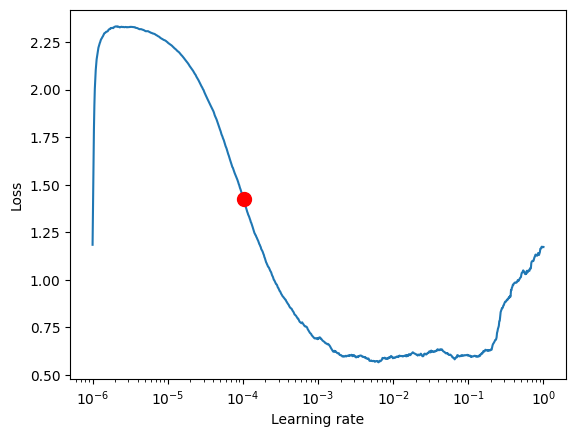

In [ ]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=64

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup('train')
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-6, max_lr=1, num_training=1000, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)


# Overfit Small Subset

In [ ]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=128
trainer_config['overfit_batches']=1
lightning_module_config['others']['learning_rate']=0.005
trainer_config['max_epochs']=10
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)

trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNetFMNIST | 304 K 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 |

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.11 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.12 | Train_Loss: 2.34, Train_Metric: 0.10


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 2.27, Val_Metric: 0.14 | Train_Loss: 1.91, Train_Metric: 0.42


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 2.20, Val_Metric: 0.30 | Train_Loss: 1.51, Train_Metric: 0.53


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 2.11, Val_Metric: 0.37 | Train_Loss: 1.21, Train_Metric: 0.61


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 2.08, Val_Metric: 0.32 | Train_Loss: 1.02, Train_Metric: 0.75


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 2.08, Val_Metric: 0.26 | Train_Loss: 0.85, Train_Metric: 0.78


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 2.04, Val_Metric: 0.30 | Train_Loss: 0.69, Train_Metric: 0.77


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 2.01, Val_Metric: 0.32 | Train_Loss: 0.55, Train_Metric: 0.83


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 2.14, Val_Metric: 0.32 | Train_Loss: 0.43, Train_Metric: 0.88


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 2.14, Val_Metric: 0.30 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Train_Loss: 0.35, Train_Metric: 0.95


In [ ]:
len(dm.trainset)//128, dm.batch_size, len(dm.train_dataloader())

(375, 128, 375)

# Regularization -I


INFO:lightning_fabric.utilities.seed:Global seed set to 42
wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs exists and is not emp

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.14 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.42, Val_Metric: 0.85 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.423


Train_Loss: 0.49, Train_Metric: 0.82


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.31, Val_Metric: 0.89 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 0.307


Train_Loss: 0.32, Train_Metric: 0.88


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.29, Val_Metric: 0.89 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.294


Train_Loss: 0.28, Train_Metric: 0.90


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.35, Val_Metric: 0.87 | Train_Loss: 0.27, Train_Metric: 0.90
Epoch 00004: reducing learning rate of group 0 to 2.5000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.27, Val_Metric: 0.90 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.265


Train_Loss: 0.22, Train_Metric: 0.92


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.26, Val_Metric: 0.91 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.261


Train_Loss: 0.20, Train_Metric: 0.93


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 0.27, Val_Metric: 0.90 | Train_Loss: 0.19, Train_Metric: 0.93
Epoch 00007: reducing learning rate of group 0 to 1.2500e-03.


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 0.21, Val_Metric: 0.92 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.215


Train_Loss: 0.15, Train_Metric: 0.95


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.22, Val_Metric: 0.92 | Train_Loss: 0.13, Train_Metric: 0.95
Epoch 00009: reducing learning rate of group 0 to 6.2500e-04.


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.23, Val_Metric: 0.92 | Train_Loss: 0.10, Train_Metric: 0.97


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.24, Val_Metric: 0.92 | Train_Loss: 0.08, Train_Metric: 0.97
Epoch 00011: reducing learning rate of group 0 to 3.1250e-04.


Validation: 0it [00:00, ?it/s]

Epoch 12: Val_Loss: 0.24, Val_Metric: 0.93 | Train_Loss: 0.06, Train_Metric: 0.98


Validation: 0it [00:00, ?it/s]

Epoch 13: Val_Loss: 0.26, Val_Metric: 0.92 | 

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.215. Signaling Trainer to stop.


Train_Loss: 0.04, Train_Metric: 0.99
Epoch 00013: reducing learning rate of group 0 to 1.5625e-04.


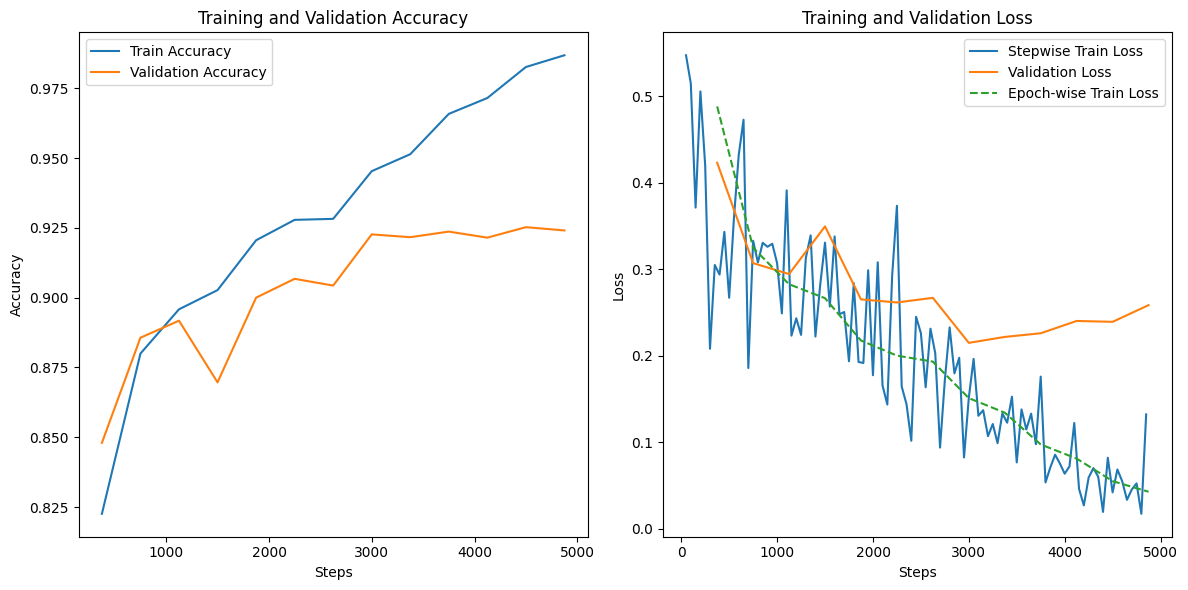

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/epoch=7-step=3000-v2.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/epoch=7-step=3000-v2.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 14: Val_Loss: 0.13, Val_Metric: 0.96 | 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/epoch=7-step=3000-v2.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/epoch=7-step=3000-v2.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 14: Val_Loss: 0.21, Val_Metric: 0.92 | Train Accuracy: 95.58
Validation Accuracy: 92.27


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
lr-AdamW,████▄▄▄▂▂▁▁▁▁
train_loss_epoch,█▅▅▅▄▃▃▃▂▂▂▁▁
train_loss_step,█▆▆▅▄▇▅▅▅▄▄▄▅▄▃▃▃▃▆▃▄▄▃▃▃▂▂▂▃▂▂▂▂▂▁▁▂▁▁▂
train_metric,▁▃▄▄▅▅▆▆▆▇▇██
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▅▆▄▄▄▃▃▃▄▄▄▁▃
val_metric,▁▃▄▂▄▅▅▆▆▆▆▆▆█▆
epoch,13
lr-AdamW,0.00031
train_loss_epoch,0.04272


In [ ]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
trainer_config['max_epochs']=25
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=50

lightning_module_config['others']['optimizer_params']['weight_decay']=0.1
lightning_module_config['others']['learning_rate']=0.005
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.ReduceLROnPlateau'
lightning_module_config['scheduler_params']= {'mode': 'max', 'patience': 0, 'factor': 0.5, 'verbose': True}
lightning_module_config['scheduler_options']= {'monitor': 'val_metric', 'interval': 'epoch', 'frequency': 1}

cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='fmnist'
cl_config['wandb']['name']='simpleresnet'

data_module_config['data_module']['batch_size']=128


model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)

trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

# Regularization -II
- Use one Cycle Learning Rate instead of Reduce Learning Rate on Plateau

INFO:lightning_fabric.utilities.seed:Global seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs exists and is not emp

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.14 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.44, Val_Metric: 0.83 | Train_Loss: 0.48, Train_Metric: 0.83


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.50, Val_Metric: 0.83 | Train_Loss: 0.35, Train_Metric: 0.87


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.33, Val_Metric: 0.88 | Train_Loss: 0.30, Train_Metric: 0.89


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.29, Val_Metric: 0.89 | Train_Loss: 0.27, Train_Metric: 0.90


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.29, Val_Metric: 0.89 | Train_Loss: 0.25, Train_Metric: 0.91


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.24, Val_Metric: 0.91 | Train_Loss: 0.22, Train_Metric: 0.92


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 0.22, Val_Metric: 0.92 | Train_Loss: 0.19, Train_Metric: 0.93


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 0.22, Val_Metric: 0.92 | Train_Loss: 0.15, Train_Metric: 0.94


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.21, Val_Metric: 0.93 | Train_Loss: 0.11, Train_Metric: 0.96


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.20, Val_Metric: 0.93 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Train_Loss: 0.08, Train_Metric: 0.97


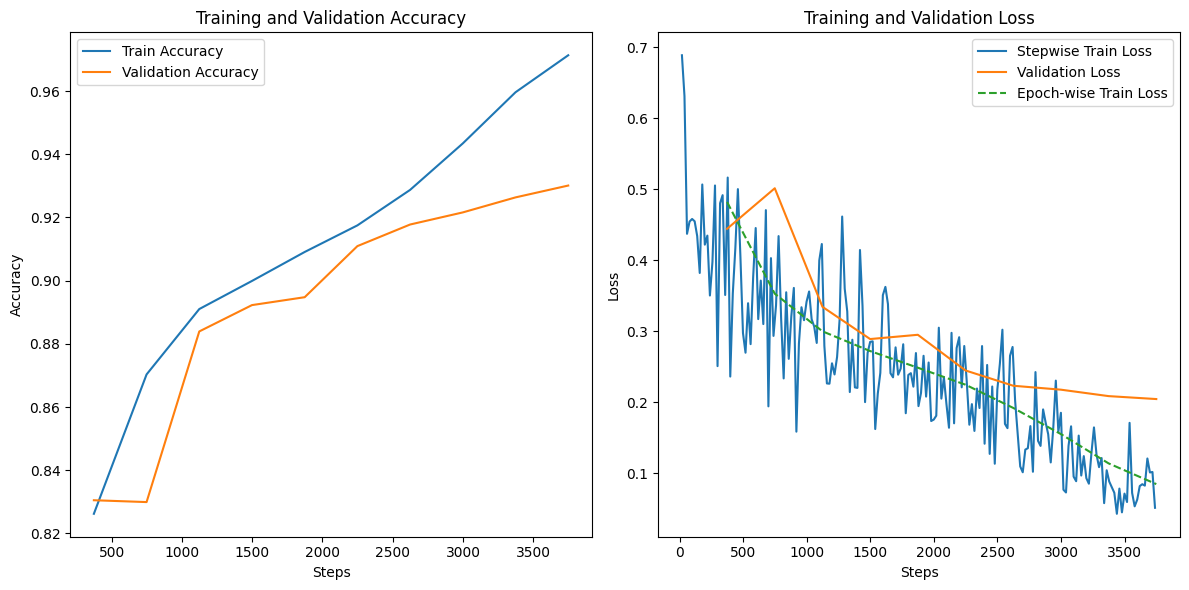

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/epoch=9-step=3750-v3.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/epoch=9-step=3750-v3.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.07, Val_Metric: 0.98 | 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/epoch=9-step=3750-v3.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/epoch=9-step=3750-v3.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.20, Val_Metric: 0.93 | Train Accuracy: 97.51
Validation Accuracy: 93.01


epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
lr-AdamW,▂▃▃▅▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train_loss_epoch,█▆▅▄▄▃▃▂▂▁
train_loss_step,█▆▅▆▃▅▆▆▄▄▄▄▃▄▄▄▄▄▃▃▄▂▃▄▂▃▂▂▂▂▂▃▁▁▂▂▁▁▁▂
train_metric,▁▃▄▅▅▅▆▇▇█
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▇█▅▅▅▄▃▃▃▃▁▃
val_metric,▁▁▄▄▄▅▅▅▆▆█▆
epoch,10
lr-AdamW,0.0
train_loss_epoch,0.08448


In [ ]:
free_memory()
seed_everything(42)

model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
trainer_config['max_epochs']=10
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20


cl_config['lr_monitor']['logging_interval']='step'
cl_config['wandb']['project']='fmnist'
cl_config['wandb']['name']='simpleresnet'

data_module_config['data_module']['batch_size']=128



lightning_module_config['others']['optimizer_params']['weight_decay']=0.05
lightning_module_config['others']['learning_rate']=0.005

lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

lightning_module_config['scheduler_params'] = {
    'max_lr': 0.01,  # Example value, adjust as necessary
    'epochs': 10,  # Optional: Total number of epochs.
    'steps_per_epoch': 375,  # Optional: Number of steps per epoch.
    'pct_start': 0.2,  # Percentage of the cycle (in number of steps) spent increasing the learning rate.
    'anneal_strategy': 'cos',  # {'cos', 'linear'}
    'cycle_momentum': True,
    'base_momentum': 0.85,
    'max_momentum': 0.95,
    'div_factor': 5.0,
    'final_div_factor': 1e4,
    'last_epoch': -1,
    'verbose': False
}

lightning_module_config['scheduler_options'] = {
    'monitor': 'val_metric',  # Adjust based on your validation metric's name
    'interval': 'step',  # The interval (either 'step' or 'epoch') at which the scheduler updates its learning rate.
    'frequency': 1  # The frequency of the scheduler updates in terms of the chosen interval.
}


model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=False )

trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

# Regularization III

INFO:lightning_fabric.utilities.seed:Global seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs exists and is not emp

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.14 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.71, Val_Metric: 0.73 | Train_Loss: 0.51, Train_Metric: 0.81


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.30, Val_Metric: 0.89 | Train_Loss: 0.32, Train_Metric: 0.88


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.28, Val_Metric: 0.90 | Train_Loss: 0.27, Train_Metric: 0.90


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.28, Val_Metric: 0.90 | Train_Loss: 0.24, Train_Metric: 0.91


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.27, Val_Metric: 0.90 | Train_Loss: 0.22, Train_Metric: 0.92


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.24, Val_Metric: 0.91 | Train_Loss: 0.19, Train_Metric: 0.93


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 0.22, Val_Metric: 0.92 | Train_Loss: 0.17, Train_Metric: 0.94


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 0.22, Val_Metric: 0.92 | Train_Loss: 0.15, Train_Metric: 0.94


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.24, Val_Metric: 0.92 | Train_Loss: 0.13, Train_Metric: 0.95


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.25, Val_Metric: 0.92 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Train_Loss: 0.10, Train_Metric: 0.96


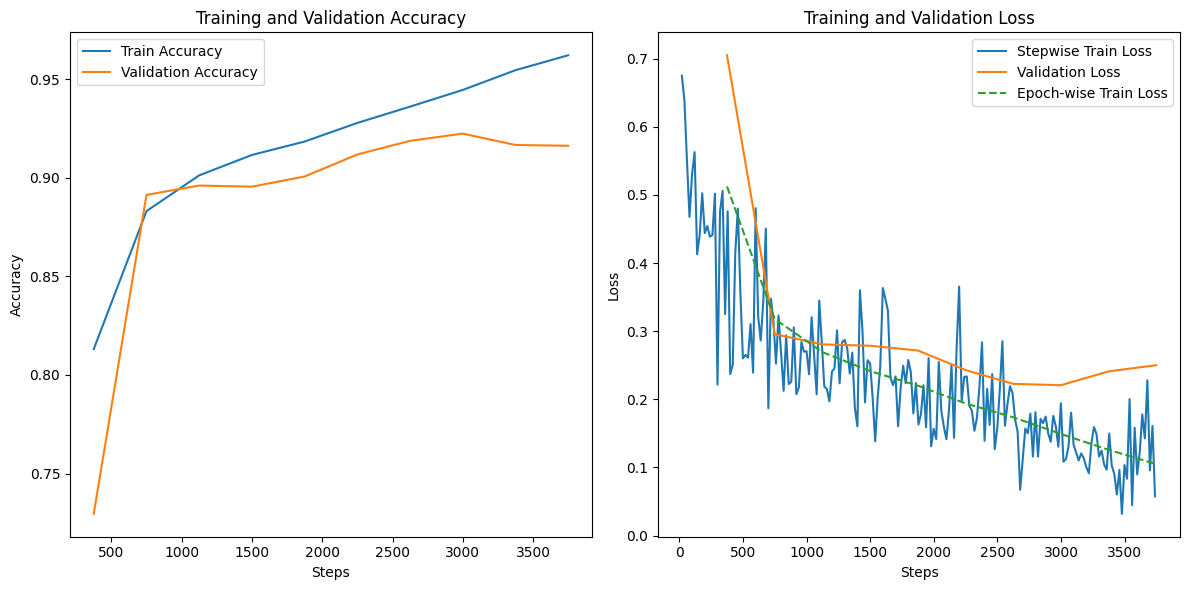

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/epoch=7-step=3000-v3.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/epoch=7-step=3000-v3.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.12, Val_Metric: 0.96 | 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/epoch=7-step=3000-v3.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/epoch=7-step=3000-v3.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.22, Val_Metric: 0.92 | Train Accuracy: 95.69
Validation Accuracy: 92.24


epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
lr-AdamW,████▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss_epoch,█▅▄▃▃▃▂▂▁▁
train_loss_step,█▇▆▆▃▅▆▆▃▃▄▄▃▄▃▄▃▄▂▃▃▂▂▅▃▃▂▂▁▂▂▂▂▂▂▂▁▁▁▂
train_metric,▁▄▅▆▆▆▇▇██
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▃▃▃▂▂▂▂▃▁▂
val_metric,▁▆▆▆▆▇▇▇▇▇█▇
epoch,10
lr-AdamW,0.00134
train_loss_epoch,0.10494


In [ ]:
free_memory()
seed_everything(42)

model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
trainer_config['max_epochs']=10
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20


cl_config['lr_monitor']['logging_interval']='step'
cl_config['wandb']['project']='fmnist'
cl_config['wandb']['name']='simpleresnet'

data_module_config['data_module']['batch_size']=128



lightning_module_config['others']['optimizer_params']['weight_decay']=0.05
lightning_module_config['others']['learning_rate']=0.01

lightning_module_config['scheduler_cls']= 'torch.optim.lr_scheduler.StepLR'
lightning_module_config['scheduler_params']= {'step_size':1, 'gamma':0.8}
lightning_module_config['scheduler_options']= {
    'monitor': 'val_metric',  # Adjust based on your validation metric's name
    'interval': 'epoch',  # The interval (either 'step' or 'epoch') at which the scheduler updates its learning rate.
    'frequency': 1  # The frequency of the scheduler updates in terms of the chosen interval.
}


model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=False )

trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()


